In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
N = 50
x = np.linspace(-20, 20, num=N)
x, y = np.meshgrid(x, x)
s = 3

def gen_data(bkg, signal_to_noise):
    g = np.exp(-0.5*(x**2+y**2)/s/s)
    
    height = signal_to_noise*bkg*N*N/g.sum()
    data = height*g + bkg
    I = (data-bkg).sum()
    data += np.random.normal(0, 1, (N, N))*np.sqrt(data)
    return data, I
    

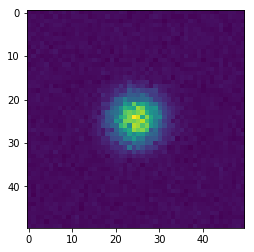

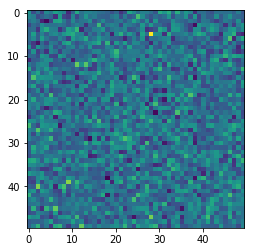

In [3]:
strong, I1 = gen_data(1, 3)
weak, I2 = gen_data(1, 0.01)

plt.imshow(strong)
plt.show()

plt.imshow(weak)
plt.show()

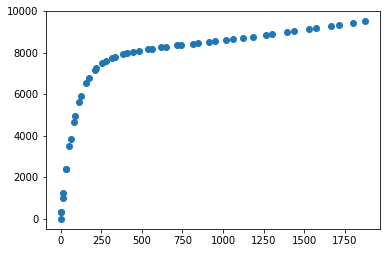

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


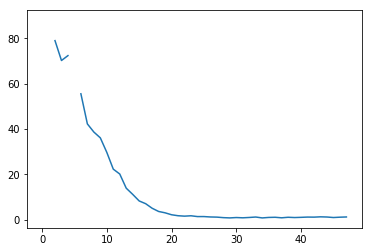

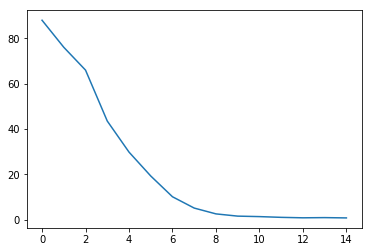

In [4]:
def mask(r0, r1):
    rr = (x**2+y**2) 
    return (rr >= r0**2)*(rr < r1**2)


def bkg(data, r0, r1):
    m = mask(r0, r1)
    return (data*m).sum() / m.sum()

def shells(data, r0, r1):
    r = np.linspace(r0, r1)
    counts = []
    points = []
    
    for i in range(1,len(r)):
        m = mask(0, r[i])
        points.append(m.sum())
        counts.append((data*m).sum())
        
    return np.array(points), np.array(counts)
    
    
p, c = shells(strong, 0, 20)

plt.scatter(p, c)
plt.show()

avg = []

for i in range(1,len(c)):
    avg.append((c[i]-c[i-1]) / (p[i]-p[i-1]))
    
plt.plot(avg)
plt.show()
    
    
b = []

for i in range(15):
    b.append(bkg(strong, i, i+1))
    
plt.plot(b)
plt.show()

In [5]:
def get_shells(r1, r2, num):
    volume = np.pi*(r2**2-r1**2)
    dv = volume / num
    
    r = [r1]
    
    for k in range(1,num):
        rk = np.power(dv/np.pi+r[k-1]**2, 1/2.0)
        r.append(rk)
        
    return np.array(r)


def integrate_shells(data, r1, r2):
    bkg_mask = mask(r1, r2)
    shells = get_shells(2, r1, 20)
    
    Is = []
    sigmas = []
    counts = []
    
    bkg = (data*bkg_mask).sum() / bkg_mask.sum()
    std_bkg = ((data-bkg)**2 * bkg_mask).sum() / bkg_mask.sum()
    
    for r in shells:
        m = mask(0, r)
        I = ((data-bkg)*m).sum()
        sigma2 = (data*m).sum() + m.sum()**2 / bkg_mask.sum() * std_bkg**2
        Is.append(I)
        sigmas.append(np.sqrt(sigma2))
        counts.append(m.sum())
        
    return shells, np.array(Is), np.array(sigmas)
        


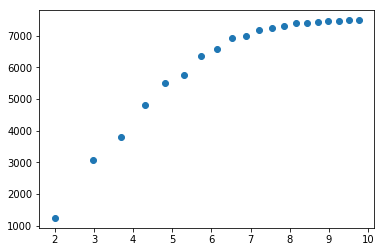

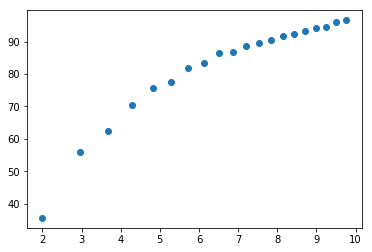

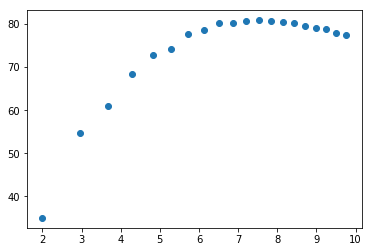

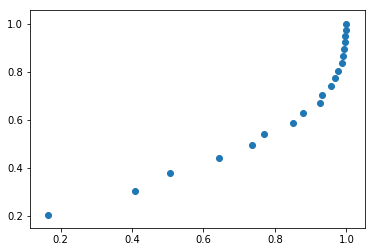

In [6]:
strong_counts, strong_I, strong_sig = integrate_shells(strong, 10, 12)


plt.scatter(strong_counts, strong_I)
plt.show()

plt.scatter(strong_counts, strong_sig)
plt.show()

plt.scatter(strong_counts, strong_I/strong_sig)
plt.show()

plt.scatter(strong_I/strong_I.max(), strong_counts/strong_counts.max())
plt.show()

# notation from paper
xp = strong_I/strong_I.max()
pp0 = strong_counts/strong_counts.max()

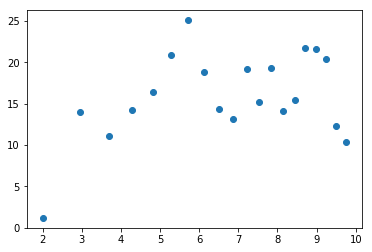

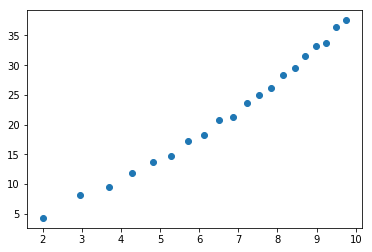

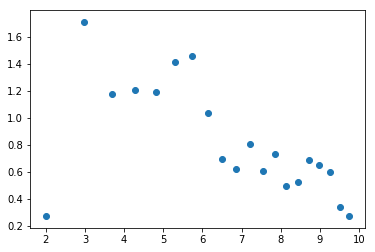

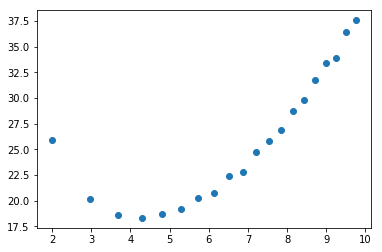

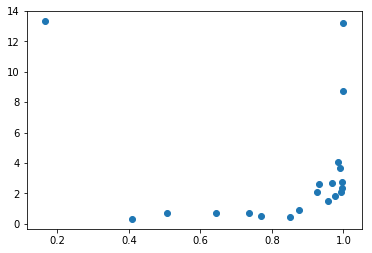

intensity estimate 34.34417941517499
exact intensity 25.000000000000004
(I_fit-I_exact)/sigma 0.46456281372270875
I_fit/sigma 1.7074831202620309


In [7]:
weak_counts, weak_I, weak_sig = integrate_shells(weak, 10, 12)

plt.scatter(weak_counts, weak_I)
plt.show()

plt.scatter(weak_counts, weak_sig)
plt.show()

plt.scatter(weak_counts, weak_I/weak_sig)
plt.show()

plt.scatter(weak_counts, weak_sig/xp)
plt.show()

# function to be minimized
sig_Ix = weak_sig**2 / weak_I**2 + strong_sig**2 / strong_I**2
plt.scatter(xp, sig_Ix)
plt.show()

best = np.argmin(sig_Ix)
Ix = weak_I[best] / xp[best]
print("intensity estimate", Ix)
print("exact intensity", I2)
print("(I_fit-I_exact)/sigma", (Ix-I2) / np.sqrt(sig_Ix[best])/Ix)
print("I_fit/sigma", 1.0/np.sqrt(sig_Ix[best]))
